In [147]:
from google.colab import drive
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import warnings
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import Callback

In [148]:
DATA_DIR = "/content/drive/MyDrive/FishImgDataset"
DATA_DIR

'/content/drive/MyDrive/FishImgDataset'

In [149]:
# List the contents of the 'val', 'train', and 'test' folders.
for folder in ['val', 'train', 'test']:
  folder_path = os.path.join(DATA_DIR, folder)
  if os.path.exists(folder_path):
    print(f"Contents of '{folder}' folder:")
    for item in os.listdir(folder_path):
      item_path = os.path.join(folder_path, item)
      print(f"  - {item} (directory: {os.path.isdir(item_path)})")
  else:
    print(f"'{folder}' folder not found in the specified directory.")


Contents of 'val' folder:
  - Snakehead (directory: True)
  - Freshwater Eel (directory: True)
  - Tilapia (directory: True)
  - Fourfinger Threadfin (directory: True)
  - Catfish (directory: True)
  - Tenpounder (directory: True)
  - Big Head Carp (directory: True)
  - Glass Perchlet (directory: True)
  - Climbing Perch (directory: True)
  - Black Spotted Barb (directory: True)
  - Bangus (directory: True)
  - Janitor Fish (directory: True)
  - Gold Fish (directory: True)
  - Indo-Pacific Tarpon (directory: True)
  - Goby (directory: True)
  - Grass Carp (directory: True)
  - Indian Carp (directory: True)
  - Green Spotted Puffer (directory: True)
  - Gourami (directory: True)
  - Knifefish (directory: True)
  - Pangasius (directory: True)
  - Silver Perch (directory: True)
  - Jaguar Gapote (directory: True)
  - Silver Barb (directory: True)
  - Silver Carp (directory: True)
  - Long-Snouted Pipefish (directory: True)
  - Mullet (directory: True)
  - Mosquito Fish (directory: True)
 

In [150]:
# Count the number of items in each subfolder within 'val', 'train', and 'test'.
for folder in ['val', 'train', 'test']:
  folder_path = os.path.join(DATA_DIR, folder)
  if os.path.exists(folder_path):
    print(f"\nCounts for '{folder}' folder:")
    for subfolder in os.listdir(folder_path):
      subfolder_path = os.path.join(folder_path, subfolder)
      if os.path.isdir(subfolder_path):
        item_count = len(os.listdir(subfolder_path))
        print(f"  - {subfolder}: {item_count} items")
  else:
    print(f"'{folder}' folder not found in the specified directory.")



Counts for 'val' folder:
  - Snakehead: 72 items
  - Freshwater Eel: 84 items
  - Tilapia: 95 items
  - Fourfinger Threadfin: 60 items
  - Catfish: 97 items
  - Tenpounder: 87 items
  - Big Head Carp: 63 items
  - Glass Perchlet: 124 items
  - Climbing Perch: 48 items
  - Black Spotted Barb: 63 items
  - Bangus: 52 items
  - Janitor Fish: 89 items
  - Gold Fish: 65 items
  - Indo-Pacific Tarpon: 57 items
  - Goby: 189 items
  - Grass Carp: 378 items
  - Indian Carp: 81 items
  - Green Spotted Puffer: 34 items
  - Gourami: 97 items
  - Knifefish: 100 items
  - Pangasius: 61 items
  - Silver Perch: 88 items
  - Jaguar Gapote: 72 items
  - Silver Barb: 105 items
  - Silver Carp: 75 items
  - Long-Snouted Pipefish: 81 items
  - Mullet: 55 items
  - Mosquito Fish: 80 items
  - Perch: 91 items
  - Mudfish: 60 items
  - Scat Fish: 48 items

Counts for 'train' folder:
  - Big Head Carp: 201 items
  - Grass Carp: 1222 items
  - Fourfinger Threadfin: 192 items
  - Bangus: 171 items
  - Gold Fis

In [151]:
# Count the total number of files in each of the three folders ('val', 'train', 'test').
for folder in ['val', 'train', 'test']:
  folder_path = os.path.join(DATA_DIR, folder)
  if os.path.exists(folder_path):
    total_files = 0
    for subfolder in os.listdir(folder_path):
      subfolder_path = os.path.join(folder_path, subfolder)
      if os.path.isdir(subfolder_path):
        total_files += len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
    print(f"Total number of files in '{folder}' folder: {total_files}")
  else:
    print(f"'{folder}' folder not found in the specified directory.")


Total number of files in 'val' folder: 2751
Total number of files in 'train' folder: 8821
Total number of files in 'test' folder: 1761


In [152]:
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

In [153]:
image_data = []
for folder in ['train', 'val', 'test']:
  folder_path = os.path.join(DATA_DIR, folder)
  if os.path.exists(folder_path):
    for class_folder in os.listdir(folder_path):
      class_folder_path = os.path.join(folder_path, class_folder)
      if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
          image_path = os.path.join(class_folder_path, image_file)
          if os.path.isfile(image_path):
            image_data.append({
                'image_path': image_path,
                'folder': folder,
                'class': class_folder,
                'filename': image_file
            })

df_image_data = pd.DataFrame(image_data)
print(df_image_data.head())


                                          image_path folder          class  \
0  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
1  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
2  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
3  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
4  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   

                filename  
0   Big Head Carp 15.jpg  
1  Big Head Carp 101.jpg  
2  Big Head Carp 104.jpg  
3  Big Head Carp 106.jpg  
4   Big Head Carp 11.jpg  


In [154]:
# Check for missing values in the DataFrame
print(df_image_data.isnull().sum())


image_path    0
folder        0
class         0
filename      0
dtype: int64



Class Distribution:
 class
Grass Carp               1838
Goby                      920
Glass Perchlet            600
Silver Barb               498
Knifefish                 484
Catfish                   473
Gourami                   472
Tilapia                   454
Perch                     444
Janitor Fish              433
Silver Perch              430
Tenpounder                420
Freshwater Eel            412
Indian Carp               396
Long-Snouted Pipefish     389
Mosquito Fish             387
Silver Carp               361
Snakehead                 351
Jaguar Gapote             345
Gold Fish                 312
Big Head Carp             307
Black Spotted Barb        303
Pangasius                 292
Fourfinger Threadfin      290
Mudfish                   285
Indo-Pacific Tarpon       282
Mullet                    267
Bangus                    257
Scat Fish                 235
Climbing Perch            230
Green Spotted Puffer      166
Name: count, dtype: int64


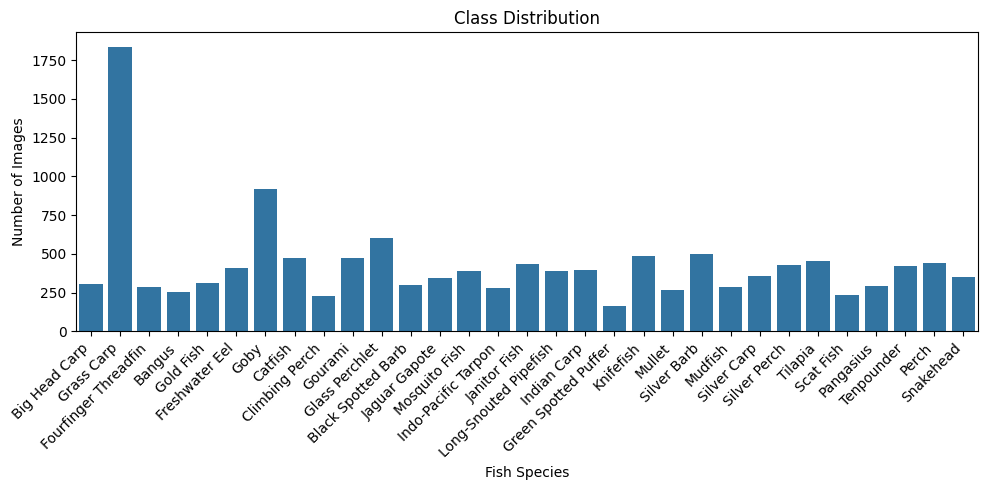


Class Distribution per Folder:

train:
class
Grass Carp               1222
Goby                      607
Glass Perchlet            399
Silver Barb               329
Knifefish                 319
Catfish                   314
Gourami                   312
Tilapia                   302
Perch                     293
Janitor Fish              286
Silver Perch              285
Tenpounder                277
Freshwater Eel            273
Indian Carp               262
Mosquito Fish             256
Long-Snouted Pipefish     256
Silver Carp               238
Snakehead                 232
Jaguar Gapote             229
Gold Fish                 206
Big Head Carp             201
Black Spotted Barb        200
Pangasius                 193
Fourfinger Threadfin      192
Mudfish                   191
Indo-Pacific Tarpon       186
Mullet                    174
Bangus                    171
Scat Fish                 154
Climbing Perch            152
Green Spotted Puffer      110
Name: count, dtype: int6

In [155]:
class_counts = df_image_data['class'].value_counts()
print("\nClass Distribution:\n", class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='class', data=df_image_data)
plt.title('Class Distribution')
plt.xlabel('Fish Species')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Class distribution per folder
print("\nClass Distribution per Folder:")
for folder in ['train', 'val', 'test']:
    print(f"\n{folder}:")
    print(df_image_data[df_image_data['folder'] == folder]['class'].value_counts())


In [156]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'class' column
df_image_data['class_encoded'] = le.fit_transform(df_image_data['class'])

# Print the mapping between original class labels and encoded labels
print("\nClass Label Mapping:")
for original_class, encoded_class in zip(le.classes_, le.transform(le.classes_)):
    print(f"{original_class}: {encoded_class}")

# Display the first few rows of the DataFrame with the encoded class labels
print("\nDataFrame with Encoded Labels:")
print(df_image_data.head())



Class Label Mapping:
Bangus: 0
Big Head Carp: 1
Black Spotted Barb: 2
Catfish: 3
Climbing Perch: 4
Fourfinger Threadfin: 5
Freshwater Eel: 6
Glass Perchlet: 7
Goby: 8
Gold Fish: 9
Gourami: 10
Grass Carp: 11
Green Spotted Puffer: 12
Indian Carp: 13
Indo-Pacific Tarpon: 14
Jaguar Gapote: 15
Janitor Fish: 16
Knifefish: 17
Long-Snouted Pipefish: 18
Mosquito Fish: 19
Mudfish: 20
Mullet: 21
Pangasius: 22
Perch: 23
Scat Fish: 24
Silver Barb: 25
Silver Carp: 26
Silver Perch: 27
Snakehead: 28
Tenpounder: 29
Tilapia: 30

DataFrame with Encoded Labels:
                                          image_path folder          class  \
0  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
1  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
2  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
3  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  Big Head Carp   
4  /content/drive/MyDrive/FishImgDataset/train/Bi...  train  

In [157]:
# Tentukan parameter untuk image augmentation (untuk training data)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
    rotation_range=30,  # Rotasi gambar dalam rentang 0-30 derajat
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2,  # Geser gambar secara vertikal
    shear_range=0.2,  # Pemotongan gambar
    zoom_range=0.2,  # Zoom gambar
    horizontal_flip=True,  # Membalik gambar secara horizontal
    fill_mode='nearest'  # Mengisi piksel kosong dengan piksel terdekat
)

In [158]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi untuk data validasi
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi untuk data uji

# Load data dari direktori menggunakan flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),  # Ukuran gambar yang akan diproses
    batch_size=32,
    class_mode='categorical'  # Kelas target menggunakan kategorikal (untuk multiclass classification)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


Contoh Gambar dari Training Set:


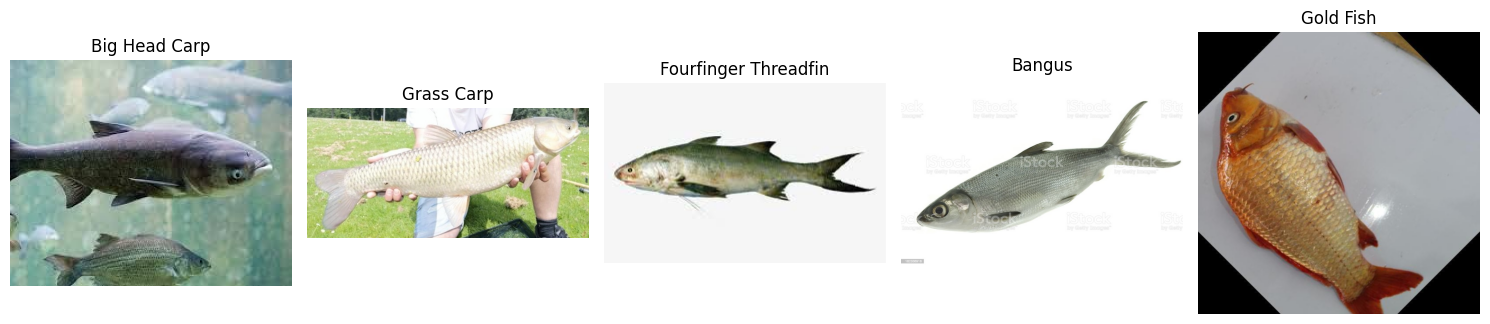


Contoh Gambar dari Validation Set:


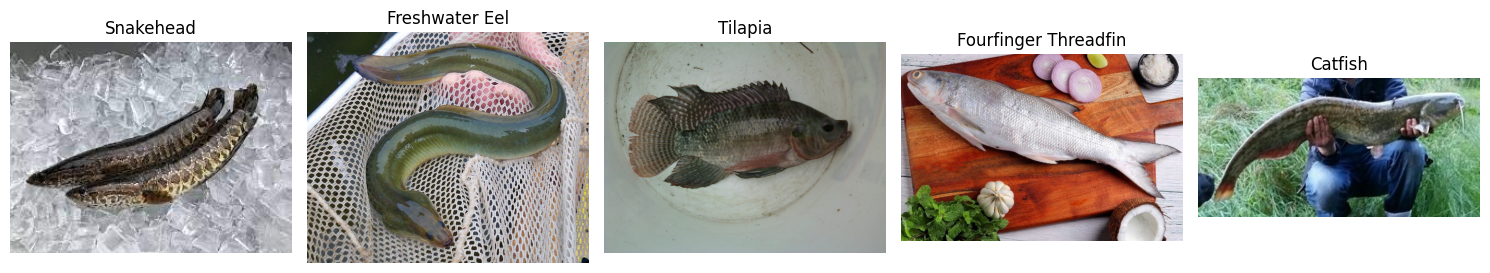


Contoh Gambar dari Test Set:


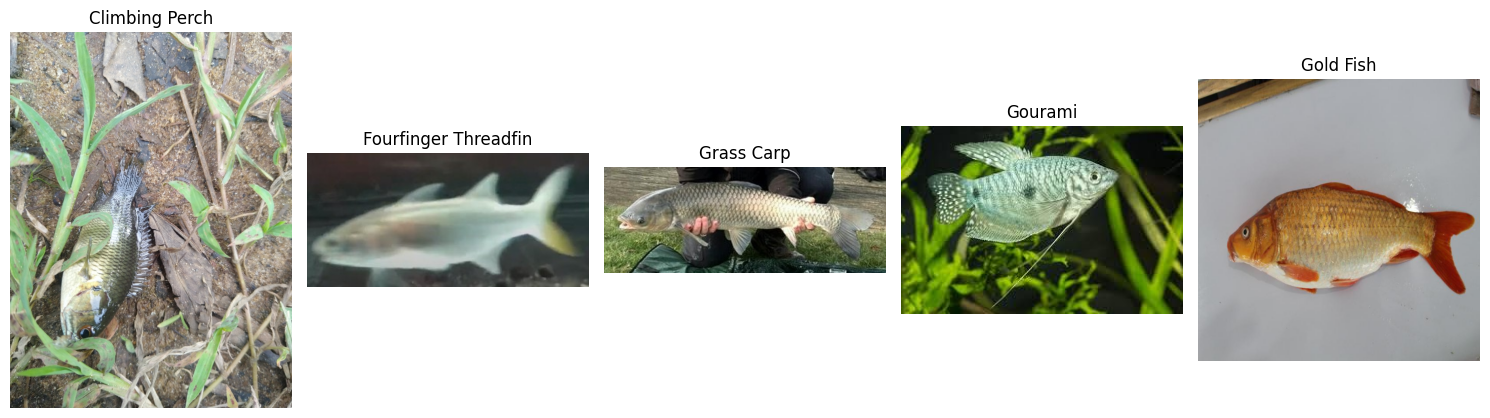

In [159]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Function to display images with their labels
def display_images(folder_path, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, class_folder in enumerate(os.listdir(folder_path)[:num_images]):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            if image_files:
                image_path = os.path.join(class_path, image_files[0]) #ambil gambar pertama
                img = mpimg.imread(image_path)
                axes[i].imshow(img)
                axes[i].set_title(class_folder)
                axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# Display images from the 'train' folder
print("Contoh Gambar dari Training Set:")
display_images(train_dir)

# Display images from the 'val' folder (optional)
print("\nContoh Gambar dari Validation Set:")
display_images(val_dir)

# Display images from the 'test' folder (optional)
print("\nContoh Gambar dari Test Set:")
display_images(test_dir)


# Model CNN

In [160]:
# Import library untuk membangun model CNN
from tensorflow.keras import layers, models

# Membangun model CNN
model = models.Sequential()

# Layer Convolutional pertama
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))  # Input shape = 150x150x3 (RGB)
model.add(layers.MaxPooling2D((2, 2)))

# Layer Convolutional kedua
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Layer Convolutional ketiga
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten output dari konvolusi untuk input ke layer fully connected
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout untuk regularisasi

# Output layer dengan softmax (untuk klasifikasi multi-kelas)
model.add(layers.Dense(len(os.listdir(train_dir)), activation='softmax'))  # jumlah kelas berdasarkan folder di dataset

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Loss untuk klasifikasi multi-kelas
              metrics=['accuracy'])

# Ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,911 (636.37 KB)

 Trainable params: 162,911 (636.37 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
fish_categories = os.listdir(train_dir)
num_classes = len(fish_categories)

In [162]:
def create_transfer_learning_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [163]:
# Create the transfer learning model
transfer_model = create_transfer_learning_model()

# Compile the model
transfer_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Model summary
transfer_model.summary()


<ipython-input-162-9327abc53f65>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,887 (9.89 MB)

 Trainable params: 335,903 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [166]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

callbacks = [early_stopping,]

In [168]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,  # You might need to adjust the number of epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)


Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 130s 470ms/step - accuracy: 0.2134 - loss: 2.9361 - val_accuracy: 0.2686 - val_loss: 2.5838
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 137s 453ms/step - accuracy: 0.2417 - loss: 2.7904 - val_accuracy: 0.2861 - val_loss: 2.4915
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 125s 450ms/step - accuracy: 0.2634 - loss: 2.6703 - val_accuracy: 0.2741 - val_loss: 2.5584
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 122s 441ms/step - accuracy: 0.2674 - loss: 2.6140 - val_accuracy: 0.2817 - val_loss: 2.5097
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 146s 455ms/step - accuracy: 0.2797 - loss: 2.5610 - val_accuracy: 0.2883 - val_loss: 2.5644
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.2977 - loss: 2.5103 - val_accuracy: 0.3417 - val_loss: 2.3037
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 121s 437ms/step - accuracy: 0.3114 - loss: 2.4661 - val_accuracy: 0.3253 - val_loss: 2.4053
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 121s 437ms/step - accuracy: 0.3214 -

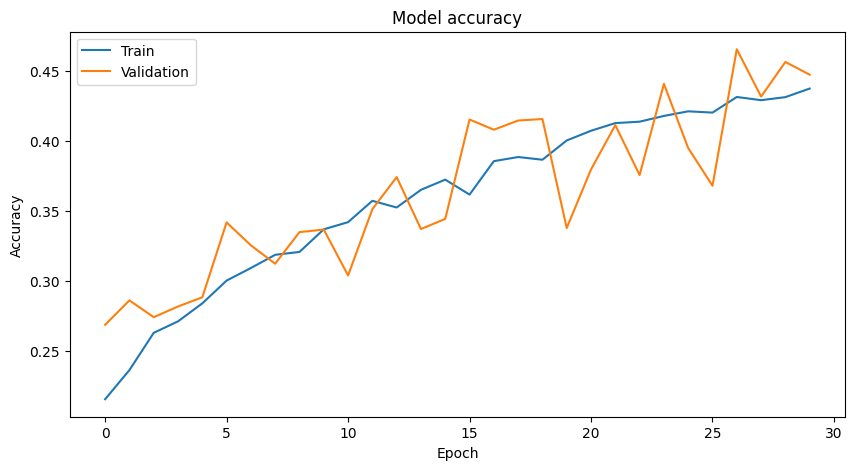

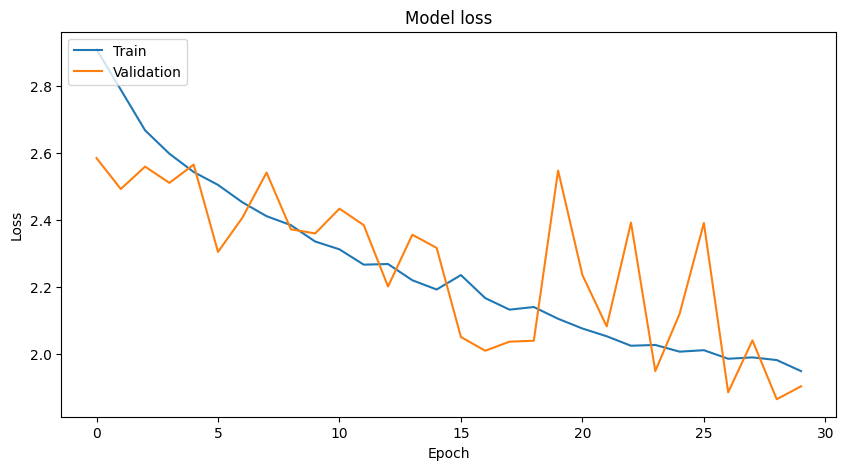

55/55 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.0362 - loss: 3.4353
Test Loss: 3.4345
Test Accuracy: 0.0335
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

               Bangus       0.01      0.12      0.03        34
        Big Head Carp       0.01      0.14      0.03        43
   Black Spotted Barb       0.02      0.03      0.02        40
              Catfish       0.00      0.00      0.00        62
       Climbing Perch       0.04      0.20      0.06        30
 Fourfinger Threadfin       0.02      0.13      0.04        38
       Freshwater Eel       0.00      0.00      0.00        55
       Glass Perchlet       0.00      0.00      0.00        77
                 Goby       0.00      0.00      0.00       124
            Gold Fish       0.00      0.00      0.00        41
              Gourami       0.04      0.03      0.04        63
           Grass Carp       0.06      0.01      0.02       238
 Green Spotted Puffer       0.03      0.05      0.04        22
          Indian Carp       0.04      0.02      0.03        53
  Indo-Pacific Tarpon       0.00      0.00      0.00  

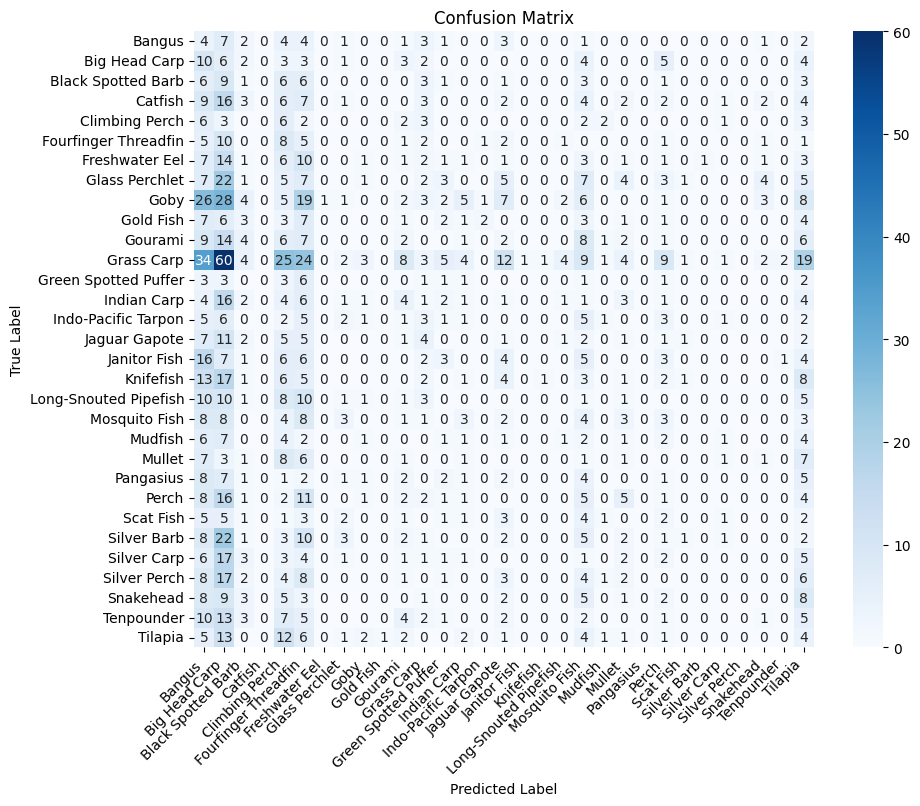

In [169]:

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
loss, accuracy = transfer_model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# Make predictions on the test set
y_pred = transfer_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate classification report
print(classification_report(y_true, y_pred_classes, target_names=list(le.classes_)))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.show()


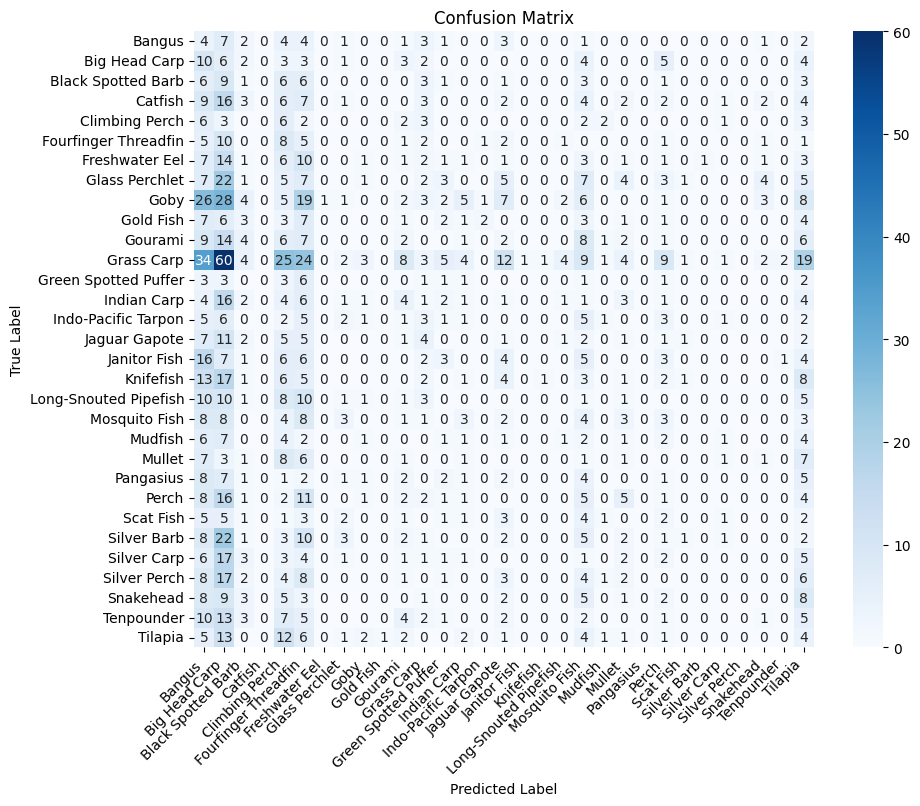

In [170]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.show()


# 📊 Analisis Hasil Klasifikasi Citra Ikan

## 1. 🔍 Data Loading dan Eksplorasi

- Dataset dimuat dari direktori Google Drive yang memiliki struktur `train`, `val`, dan `test`, dengan subfolder mewakili spesies ikan yang berbeda.
- Jumlah gambar pada tiap kategori dihitung dan distribusi kelas divisualisasikan.
  - Penting untuk memperhatikan potensi *class imbalance* yang mungkin perlu ditangani menggunakan teknik seperti *class weights*.
- Pemeriksaan nilai hilang dilakukan (meskipun ini lebih relevan pada data tabular daripada data citra langsung).
- Label encoding mengubah nama spesies ikan menjadi label numerik untuk pelatihan model.
  - Mapping dari nama asli ke nilai encoded dicetak sebagai referensi.

## 2. 🛠️ Preprocessing dan Augmentasi Data

- **ImageDataGenerator** digunakan untuk melakukan augmentasi data, yang bertujuan memperbesar dataset pelatihan secara artifisial:
  - Transformasi seperti rotasi, pergeseran, *shearing*, zoom, dan flipping diterapkan.
  - Data training menggunakan augmentasi, sedangkan data validasi dan pengujian tidak menggunakan augmentasi untuk menjaga keaslian distribusi data.
- **Normalisasi**: Semua pixel gambar diskalakan ke rentang \([0, 1]\).
- **Ukuran Gambar**: Seluruh gambar diubah ukurannya menjadi 32x32 piksel.
  - Pertimbangkan ukuran yang lebih besar jika fitur visual spesies ikan sangat kompleks.

## 3. 🧠 Pembuatan dan Pelatihan Model

### 🧱 Model CNN Sederhana

- Arsitektur CNN sederhana dibuat dengan:
  - Lapisan konvolusi
  - *MaxPooling*
  - Lapisan fully connected
- Menggunakan softmax pada layer output untuk klasifikasi multi-kelas.

### 🔄 Transfer Learning (MobileNetV2)

- MobileNetV2 digunakan sebagai model *pre-trained* dengan:
  - `include_top=False` untuk menghapus lapisan klasifikasi terakhir.
  - `base_model.trainable = False` agar bobot pretrained tidak dilatih ulang pada awal pelatihan.
- Cocok untuk dataset kecil dan mempercepat pelatihan.

### ⚙️ Kompilasi Model

- Optimizer: `Adam`
- Loss function: `categorical_crossentropy`
- Metric: `accuracy`

### ⏹️ Early Stopping

- Diterapkan untuk mencegah overfitting dengan memantau `val_loss`.
- Pelatihan berhenti otomatis jika tidak ada perbaikan selama beberapa epoch.

### 🏋️‍♀️ Pelatihan Model

- Model dilatih menggunakan `fit()` pada data training dan divalidasi dengan data validation set.

## 4. 🧪 Evaluasi Model

- **Akurasi Uji**:
  - Model dievaluasi pada dataset `test`.
  - Dicetak nilai `test loss` dan `test accuracy`.

- **Classification Report**:
  - Menampilkan *precision*, *recall*, *F1-score*, dan *support* untuk setiap kelas.

- **Confusion Matrix**:
  - Visualisasi prediksi benar vs salah pada tiap kelas.
  - Membantu mengidentifikasi kelas yang sering salah klasifikasi.

---

## 💡 Rekomendasi dan Peningkatan Potensial

- **Ukuran Gambar Lebih Besar**:
  - Coba gunakan ukuran 64x64, 128x128, atau 224x224 untuk menangkap lebih banyak informasi spasial.

- **Tuning Augmentasi**:
  - Eksperimen dengan parameter augmentasi untuk variasi yang lebih relevan.

- **Tuning Hyperparameter**:
  - Gunakan *grid search* atau *random search* untuk mengeksplorasi kombinasi terbaik dari:
    - *learning rate*
    - *batch size*
    - jumlah filter/neuron
    - arsitektur layer

- **Ketidakseimbangan Kelas**:
  - Terapkan oversampling, undersampling, atau class weights jika ditemukan *class imbalance* yang signifikan.

- **Eksplorasi Arsitektur Lain**:
  - Gunakan model lain seperti ResNet, EfficientNet, atau DenseNet.

- **Fine-Tuning Transfer Learning**:
  - Setelah pelatihan awal, unfreeze beberapa layer dari base model dan latih dengan learning rate kecil.

- **Evaluasi Tambahan**:
  - Jika distribusi kelas sangat tidak seimbang, gunakan metrik seperti ROC AUC selain akurasi.

---

## 📉 Analisis Confusion Matrix

- Fokus pada kelas dengan jumlah kesalahan klasifikasi tinggi.
- Pertimbangkan augmentasi tambahan untuk kelas tersebut.
- Lihat fitur visual yang membedakan kelas tersebut secara lebih detail.
